# Student Name: Huynh Truong Tu
 Below is my assignment for Sprint8's "Ensemble Scratch"


-----------------------------------------

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data set prep

## 1. Reg Data

In [29]:
house_price_data = pd.read_csv('houseprice_train.csv')
data = house_price_data[['SalePrice','GrLivArea','YearBuilt']]
data.head()

,SalePrice,GrLivArea,YearBuilt
0,208500,1710,2003
1,181500,1262,1976
2,223500,1786,2001
3,140000,1717,1915
4,250000,2198,2000


In [30]:
X = data.drop(columns='SalePrice').to_numpy()
Y = data['SalePrice'].to_numpy()
X.shape, Y.shape

((1460, 2), (1460,))

In [31]:
#scaling
from sklearn.preprocessing import MinMaxScaler
xscaler = MinMaxScaler()
X = xscaler.fit_transform(X)
yscaler = MinMaxScaler()
Y = yscaler.fit_transform(Y.reshape(-1,1)).ravel()
print(X[:5])
print(Y[:5])

[[0.25923135 0.94927536]
 [0.17483044 0.75362319]
 [0.27354936 0.93478261]
 [0.26055011 0.3115942 ]
 [0.35116805 0.92753623]]
[0.24107763 0.20358284 0.26190807 0.14595195 0.29870851]


In [32]:

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size= 0.2)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1168, 2), (292, 2), (1168,), (292,))

## 2. Classification Data

In [33]:
from sklearn.datasets import load_iris
iris = load_iris()
Xc = X = iris.data[:, :2]
Yc = iris.target
Xc.shape, Yc.shape, 'Class count: ', np.unique(Yc)

((150, 2), (150,), 'Class count: ', array([0, 1, 2]))

In [34]:
xc_train,xc_test,yc_train,yc_test = train_test_split(Xc,Yc, test_size= 0.2)
xc_train.shape,xc_test.shape,yc_train.shape,yc_test.shape

((120, 2), (30, 2), (120,), (30,))

# Problem 1 - Blending Scratch Mounting

## Regression Blending

### 1. Model Prototype

In [35]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import ParameterGrid
class ModelModule():
    def __init__(self, class_name, param_grid = None):
        self.class_name = class_name
        self.params_list = ParameterGrid(param_grid) if param_grid is not None else None
    def getModels(self):
        if self.params_list is None: return [self.class_name()]
        models = []
        for params in self.params_list:
            models.append(self.class_name(**params))
        return models

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
class ScratchRegBlending():
    def __init__(self, verbose = False, debug = False):
        self.verbose = verbose
        #Linear reg
        linear_reg_module = ModelModule(LinearRegression) 
        #SVR
        svr_params = [
            {
                'kernel' : ['linear']
            },
            {
                'kernel' : ['poly'],
                'degree' : [2,3,4],
            },
            {
                'kernel' : ['rbf']
            }
        ]
        svr_module = ModelModule(SVR, svr_params)
        #Decision Tree
        tree_params = {
            'criterion' : ['mse', 'mae'],
            'splitter' : ['best', 'random'],
            'max_features' : ['auto', 'sqrt'],
            'max_depth' : [None, 2, 3, 4],
        }
        deci_tree_module = ModelModule(DecisionTreeRegressor, tree_params)

        self.modules = [linear_reg_module, svr_module, deci_tree_module]
        self.models = []
        for module in self.modules:
            self.models.extend(module.getModels())
    def fit(self,X,y,X_val, y_val):
        val_result = []
        for model in self.models:
            if self.verbose: print('Fitting model: ', model)
            model.fit(X,y)
        #result
        pred_train = self.predict(X)
        pred_val = self.predict(X_val)
        self.train_score = mean_squared_error(y, pred_train)
        self.val_score = mean_squared_error(y_val, pred_val)
        if self.verbose:
            print('Train MSE: ', self.train_score)
            print('Val MSE: ', self.val_score)
    def predict(self,X):
        result = []
        for model in self.models:
            result.append(model.predict(X))
        result = np.array(result).T
        avg = np.average(result, axis = 1)
        return avg
        
ScratchRegBlending();

Fitting model:  LinearRegression()
Fitting model:  SVR(kernel='linear')
Fitting model:  SVR(degree=2, kernel='poly')
Fitting model:  SVR(kernel='poly')
Fitting model:  SVR(degree=4, kernel='poly')
Fitting model:  SVR()
Fitting model:  DecisionTreeRegressor(max_features='auto')
Fitting model:  DecisionTreeRegressor(max_features='auto', splitter='random')
Fitting model:  DecisionTreeRegressor(max_features='sqrt')
Fitting model:  DecisionTreeRegressor(max_features='sqrt', splitter='random')
Fitting model:  DecisionTreeRegressor(max_depth=2, max_features='auto')
Fitting model:  DecisionTreeRegressor(max_depth=2, max_features='auto', splitter='random')
Fitting model:  DecisionTreeRegressor(max_depth=2, max_features='sqrt')
Fitting model:  DecisionTreeRegressor(max_depth=2, max_features='sqrt', splitter='random')
Fitting model:  DecisionTreeRegressor(max_depth=3, max_features='auto')
Fitting model:  DecisionTreeRegressor(max_depth=3, max_features='auto', splitter='random')
Fitting model:  De

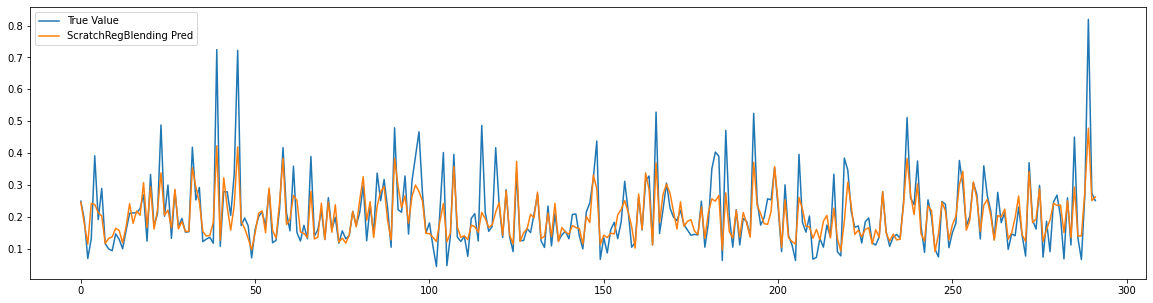

In [36]:
np.random.seed(0)
blend_model = ScratchRegBlending(verbose = True)
blend_model.fit(x_train,y_train,x_test,y_test)

plt.figure(figsize=(20,5))
plt.plot(y_test, label = 'True Value')
plt.plot(blend_model.predict(x_test), label = blend_model.__class__.__name__ + ' Pred')
plt.legend()
plt.show()

### 2. Compare Result With Base Models

In [37]:
blend_train_score,blend_val_score = blend_model.train_score,blend_model.val_score
print('Blend Train: ',blend_train_score)
print('Blend Val: ', blend_val_score)
svr = SVR()
linear = LinearRegression()
deci_tree = DecisionTreeRegressor()
for model in [svr,linear, deci_tree]:
    print(model.__class__.__name__)
    model.fit(x_train,y_train)
    pred_train = model.predict(x_train)
    pred_val = model.predict(x_test)
    train_score = mean_squared_error(pred_train, y_train)
    print('Train MSE: ', train_score, 'More err compared to Blend: ', (train_score - blend_train_score)*100 , '%')
    val_score = mean_squared_error(pred_val, y_test)
    print('Val MSE: ', val_score, 'More err compared to Blend: ', (val_score - blend_val_score)*100 , '%')

Blend Train:  0.0025746028783194415
Blend Val:  0.0040166669235612955
SVR
Train MSE:  0.003383354316228742 More err compared to Blend:  0.08087514379093003 %
Val MSE:  0.0032595795127565003 More err compared to Blend:  -0.07570874108047952 %
LinearRegression
Train MSE:  0.004258049231875577 More err compared to Blend:  0.16834463535561353 %
Val MSE:  0.004044428580804666 More err compared to Blend:  0.002776165724337025 %
DecisionTreeRegressor
Train MSE:  3.517660513849329e-05 More err compared to Blend:  -0.25394262731809486 %
Val MSE:  0.005606578843501463 More err compared to Blend:  0.15899119199401676 %


> Some thought:
* Blend has better fitting than some models (SVR, Linear) but worse than Tree. It's validation is okay compared with others models.
* We need to choose carefully which model to blend since the average results depend on that.

## Blend Classification

In [38]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
class ScratchClsBlending:
    def __init__(self,verbose = False):
        self.verbose = verbose
        models = []
        models.append(('LR', 
                  LogisticRegression(solver ='lbfgs', 
                                     multi_class ='multinomial', 
                                     max_iter = 200)))
        models.append(('SVC', SVC(gamma ='auto', probability = True)))
        models.append(('DTC', DecisionTreeClassifier()))
        self.model = VotingClassifier(estimators = models, voting = 'soft')
    def fit(self,X,y,X_val = None,y_val = None):
        self.model.fit(X,y)
        if self.verbose:
            train_pred = self.predict(X)
            val_pred = self.predict(X_val)
            self.train_score = accuracy_score(y,train_pred)
            if y_val is not None:
                self.val_score = accuracy_score(y_val, val_pred)
                print('Train Acc: ', self.train_score)
                print('Val Acc: ', self.val_score)
    def predict(self,X):
        return self.model.predict(X)

blend_cls_model = ScratchClsBlending(verbose= True)
blend_cls_model.fit(xc_train,yc_train,xc_test,yc_test)

Train Acc:  0.9166666666666666
Val Acc:  0.7


> ### Compare Blending with SVC, LR & DTC

In [39]:
blend_cls = ScratchClsBlending()
svc = SVC()
logis = LogisticRegression(max_iter=1000)
deci = DecisionTreeClassifier()
for model in [blend_cls,svc,logis, deci]:
    print(model.__class__.__name__)
    model.fit(xc_train,yc_train)
    pred_train = model.predict(xc_train)
    pred_val = model.predict(xc_test)
    train_score = accuracy_score(pred_train, yc_train)
    print('Train Acc: ', train_score)
    val_score = accuracy_score(pred_val, yc_test)
    print('Val Acc: ', val_score)

ScratchClsBlending
Train Acc:  0.9166666666666666
Val Acc:  0.7
SVC
Train Acc:  0.8083333333333333
Val Acc:  0.7
LogisticRegression
Train Acc:  0.825
Val Acc:  0.7333333333333333
DecisionTreeClassifier
Train Acc:  0.9416666666666667
Val Acc:  0.7


> As you can see, the fitting of ScratchClsBlending is one of the highest but I believe that some models are not doing well and thus lowering the average result.

In [67]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01,x_test = None, y_test = None, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    # settings
    scatter_color = ['red', 'blue','orange']
    contourf_color =  ['pink', 'skyblue', 'navajowhite']
    n_class = 3

    # prepare meshgrid
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]

    # predict
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    #plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)

    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label='Train: '+ target_names[i], marker='o', alpha = 0.3)
    if not x_test is None:
        for i,target in enumerate(set(y_test)):
            plt.scatter(x_test[y_test==target][:, 0], x_test[y_test==target][:, 1], s=10, color=scatter_color[i], label= 'Test: ' +target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

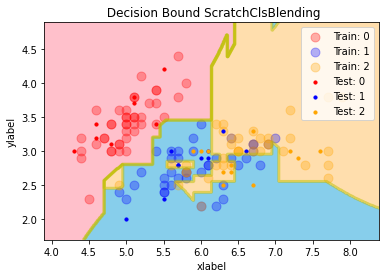

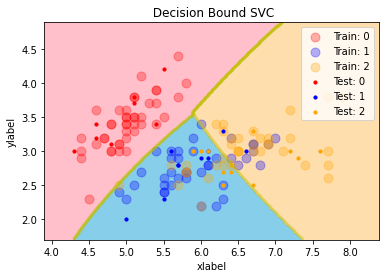

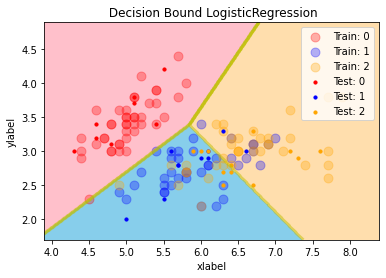

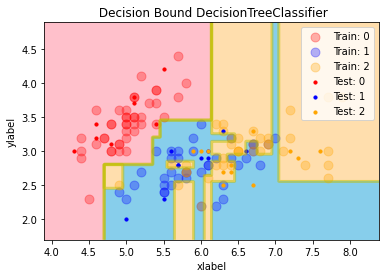

In [68]:
for model in [blend_cls,svc,logis, deci]:
    decision_region(xc_train,yc_train,model, x_test = xc_test, y_test = yc_test, title = ' Decision Bound ' + model.__class__.__name__, target_names= ['0','1','2'])

> Personally I think the shape of Blend models look a bit overfitting. 

# Problem 2 - Sratch Mounting of Bagging

## Bagging Prototype

In [42]:
from sklearn.base import clone
class ScratchBaggingModel():
    def __init__(self, model, max_iter = 100, subset_size = 0.2, verbose = False, mode = 'Regression'):
        self.mode = mode
        self.verbose = verbose
        self.model = model
        self.iter = max_iter
        self.subset_size = subset_size
    def fit(self,X,y,X_val = None, y_val = None):
        if self.mode == 'Classification':
            self.labels = np.sort(np.unique(y))
        split_seeds = np.arange(self.iter)
        self.models = []
        for i in range(self.iter):
            model = clone(self.model)
            Xi,_,yi,_ = train_test_split(X,y, train_size= self.subset_size, random_state = split_seeds[i])
            model.fit(Xi,yi)
            self.models.append(model)
        if self.mode == 'Regression':
            self.train_score = mean_squared_error(y, self.predict(X))
            if y_val is not None:
                self.val_score = mean_squared_error(y_val, self.predict(X_val))
        else:
            self.train_score = accuracy_score(y, self.predict(X))
            if y_val is not None:
                self.val_score = accuracy_score(y_val, self.predict(X_val))
    def predict(self,X):
        if self.mode == 'Regression':
            result = []
            for model in self.models:
                result.append(model.predict(X))
            return np.average(result, axis = 0)
        else: #classification
            proba_result = []
            for model in self.models:
                proba_result.append(model.predict_proba(X))
            proba_result = np.average(proba_result, axis = 0)
            pred_label = np.zeros(len(X))
            for i in range(len(X)):
                pred_label[i] = self.labels[np.argmax(proba_result[i])]
            return pred_label

### Compare with blending

In [43]:
#bag model
bag_reg_model = ScratchBaggingModel(DecisionTreeRegressor())
bag_reg_model.fit(x_train,y_train,x_test,y_test)
bagging_train_err,bagging_val_err = bag_reg_model.train_score, bag_reg_model.val_score
print('Bagging Train err: ', bagging_train_err, 'Bagging val err: ', bagging_val_err)

#blend model
blend_model = ScratchRegBlending()
blend_model.fit(x_train,y_train,x_test,y_test)
blend_train_err,blend_val_err = blend_model.train_score, blend_model.val_score
print('Blend Train err: ', blend_train_err, 'Blend val err: ', blend_val_err)

#compare
print('Bagging has more train error of: ', (bagging_train_err - blend_train_err) / blend_train_err * 100, '%')
print('Bagging has more val error of: ', (bagging_val_err - blend_val_err) / blend_val_err * 100, '%')

Bagging Train err:  0.002271114589068434 Bagging val err:  0.0032028775184606323
Blend Train err:  0.0025394578064155144 Blend val err:  0.004061736293356205
Bagging has more train error of:  -10.56694923889486 %
Bagging has more val error of:  -21.145114130142087 %


> NOTE: comparision
* The combination of Decision Tree and Bagging is much more proficient compared to blending in both training and validation.

# Problem 3 - Stacking

In [66]:
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error
class StackRegModelScratch():
    def __init__(self, base_models = [LinearRegression(), DecisionTreeRegressor(), SVR()], meta_model = LinearRegression(), max_depth = 3, verbose = False, debug = False):
        self.base_models = base_models
        self.meta_model = meta_model
        self.max_depth = max_depth
        self.verbose = verbose
        self.debug = debug
    def _stack(self, X,y): 
        self.meta_model.fit(X,y)
    def _blend(self,X,y, base_model,current_depth):
        if self.debug:
            print('Blending: ', base_model.__class__.__name__)
        seed = self.kfold_seed[current_depth]
        KF = KFold(n_splits= self.K, random_state=seed, shuffle=True)
        blended_prediction = np.zeros(X.shape[0])
        
        for train_idx, val_idx in KF.split(X):
            x_train,y_train = X[train_idx], y[train_idx]
            x_val, y_val = X[val_idx], y[val_idx]
            fit_model = clone(base_model)
            self.fitted_models[current_depth].append(fit_model.fit(x_train,y_train))
            blended_prediction[val_idx] = fit_model.predict(x_val)
        return blended_prediction
    def fit(self,X,y, kfold = 5, seed = 0):
        np.random.seed(0)
        self.K = kfold
        self.kfold_seed = np.arange(self.max_depth)
        self.fitted_models = {}
        #blending loop
        init_X = X
        for current_depth in range(0, self.max_depth):
            if self.debug: 
                print('Cur depth: ', current_depth)
                print('X s: ', X.shape)
            meta_data = np.zeros((len(self.base_models), X.shape[0]))
            self.fitted_models[current_depth] = [] 
            for i, base in enumerate(self.base_models):
                meta_data[i] = self._blend(X,y,base,current_depth)
            X = meta_data.T # flip meta_data and use that to train next ilteration
        #stacking: last depth, learn with meta model
        self._stack(X,y)
        #scoring
        if self.verbose:
            train_pred = self.predict(init_X)
            print('Err: ', mean_squared_error(train_pred,y))
    def _get_fitted_model(self,ilteration):
        return self.fitted_models[ilteration]
    def predict(self, X):
        for current_depth in range(self.max_depth):
            meta_data = np.zeros((X.shape[0], len(self.base_models)))
            avg_prob = np.zeros(X.shape[0], )
            for i, model in enumerate(self._get_fitted_model(current_depth)):
                avg_prob += model.predict(X)
                if i % self.K == (self.K-1):
                    avg_prob /= self.K 
                    meta_data[:,i // self.K] = avg_prob
                    avg_prob =  np.zeros(X.shape[0])
            X = meta_data
        return self.meta_model.predict(meta_data)

stack_model = StackRegModelScratch(verbose = True, debug = False)
stack_model.fit(x_train,y_train)

Err:  0.002902307805131486


### Compare with bagging

Stack train err:  0.002902307805131486 more compared to bag:  0.0006311932160630519
Stack val err:  0.0031852168625852093 more compared to bag:  -1.7660655875423054e-05


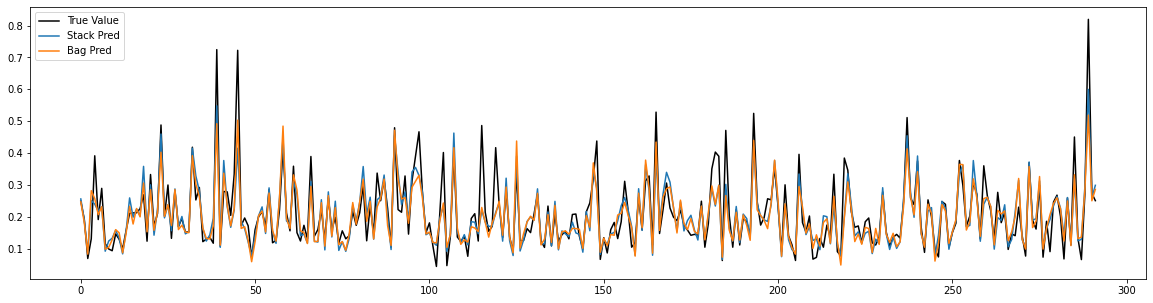

In [55]:
stack_train_err = mean_squared_error(stack_model.predict(x_train), y_train)
stack_val_err = mean_squared_error(stack_model.predict(x_test), y_test)

print('Stack train err: ', stack_train_err, 'more compared to bag: ', stack_train_err - bagging_train_err)
print('Stack val err: ', stack_val_err, 'more compared to bag: ', stack_val_err - bagging_val_err)

plt.figure(figsize=(20,5))
plt.plot(y_test, label = 'True Value', c = 'black')
plt.plot(stack_model.predict(x_test), label = 'Stack Pred')
plt.plot(bag_reg_model.predict(x_test), label = 'Bag Pred')
plt.legend()
plt.show()

### Compare with base models

In [56]:
for model in [svr,linear, deci_tree]:
    print(model.__class__.__name__)
    model.fit(x_train,y_train)
    pred_train = model.predict(x_train)
    pred_val = model.predict(x_test)
    train_score = mean_squared_error(pred_train, y_train)
    print('Train MSE: ', train_score, 'More err compared with stack: ', (train_score - stack_train_err)*100 , '%')
    val_score = mean_squared_error(pred_val, y_test)
    print('Val MSE: ', val_score, 'More err compared with stack: ', (val_score - stack_val_err)*100 , '%')

SVR
Train MSE:  0.003383354316228742 More err compared with stack:  0.04810465110972558 %
Val MSE:  0.0032595795127565003 More err compared with stack:  0.007436265017129106 %
LinearRegression
Train MSE:  0.004258049231875577 More err compared with stack:  0.13557414267440906 %
Val MSE:  0.004044428580804666 More err compared with stack:  0.08592117182194564 %
DecisionTreeRegressor
Train MSE:  3.517660513849329e-05 More err compared with stack:  -0.28671311999929927 %
Val MSE:  0.005589313988468313 More err compared with stack:  0.24040971258831034 %


Train Acc:  0.825
Val Pred:  0.7333333333333333


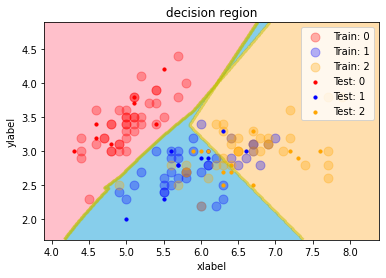

In [60]:
class StackClsScratch():
    def __init__(self, base_models = [LogisticRegression(), DecisionTreeClassifier(), SVC(probability = True)], meta_model = LogisticRegression(), max_depth = 3, verbose = False, debug = False):
        self.base_models = base_models
        self.meta_model = meta_model
        self.max_depth = max_depth
        self.verbose = verbose
        self.debug = debug

    def _stack(self, X,y): 
        self.meta_model.fit(X,y)

    def _blend(self,X,y, base_model,current_depth):
        if self.debug:
            print('Blending: ', base_model.__class__.__name__)
        seed = self.kfold_seed[current_depth]
        KF = KFold(n_splits= self.K, random_state=seed, shuffle=True)
        blended_prediction = np.zeros(X.shape[0])
        for train_idx, val_idx in KF.split(X):
            x_train,y_train = X[train_idx], y[train_idx]
            x_val, y_val = X[val_idx], y[val_idx]
            fit_model = clone(base_model)
            self.fitted_models[current_depth].append(fit_model.fit(x_train,y_train))
            blended_prediction[val_idx] = fit_model.predict(x_val)
        return blended_prediction

    def fit(self,X,y, kfold = 5, seed = 0):
        np.random.seed(0)
        self.K = kfold
        self.kfold_seed = np.arange(self.max_depth)
        self.fitted_models = {}
        self.labels = np.sort(np.unique(y))
        #blending loop
        init_X = X
        for current_depth in range(0, self.max_depth):
            if self.debug: 
                print('Cur depth: ', current_depth)
                print('X s: ', X.shape)
                print(X[:3])
            meta_data = np.zeros((len(self.base_models), X.shape[0]))
            self.fitted_models[current_depth] = [] #new ilteration of models
            for i, base in enumerate(self.base_models):
                meta_data[i] = self._blend(X,y,base,current_depth)
            X = meta_data.T 
        self._stack(X,y)
        #scoring
        if self.verbose:
            train_pred = self.predict(init_X)
            # print('Train pred: ', train_pred)
            print('Train Acc: ', accuracy_score(train_pred,y))

    def _get_fitted_model(self,ilteration):
        return self.fitted_models[ilteration]

    def predict(self, X):
        for current_depth in range(self.max_depth):
            meta_data = np.zeros((X.shape[0], len(self.base_models)))
            avg_pred = np.zeros((X.shape[0], len(self.labels)))
            for i, model in enumerate(self._get_fitted_model(current_depth)):
                avg_pred += model.predict_proba(X)
                if i % self.K == (self.K-1):
                    avg_pred /= self.K
                    meta_data[:,i // self.K] = np.argmax(avg_pred,axis = 1)
                    avg_pred = np.zeros((X.shape[0], len(self.labels)))
            if self.debug:
                print('meta pred: ', meta_data[:5])
            X = meta_data
        return self.meta_model.predict(meta_data)
        
stack_cls = StackClsScratch(verbose = True, debug = False)
stack_cls.fit(xc_train,yc_train)
pred = stack_cls.predict(xc_test)
print('Val Pred: ', accuracy_score(yc_test, pred))
decision_region(xc_train,yc_train,stack_cls,x_test= xc_test,y_test = yc_test, target_names= ['0','1','2'])

> The border of stacking is better now, not overfitting like blending.

So we have: <br />

ScratchClsBlending <br />
Train Acc:  0.91666666666666 <br />
Val Acc:  0.7 <br />
<br />
SVC <br />
Train Acc:  0.80833333333333 <br />
Val Acc:  0.7 <br />
<br />
LogisticRegression <br />
Train Acc:  0.825 <br />
Val Acc:  0.7333333333333334 <br />
<br />
DecisionTreeClassifier <br />
Train Acc:  0.94166666666667 <br />
Val Acc:  0.7 <br />
<br />
Stacking: <br />
Train Acc: 0.825 <br />
Val Acc: 0.733333333333333 <br />

--------------------------------------

This is the end of my assignment. Thank you for reading!